In [1]:
import pandas as pd
import numpy as np
import random as rd # generating random numbers
import datetime # manipulating date formats
from scipy import stats
from tqdm import tqdm_notebook
from itertools import product 

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# settings
import warnings
import platform, sys
warnings.filterwarnings("ignore")

print('Machine: {} {}'.format(platform.uname().system, platform.uname().machine))
print("Python version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))

pd.set_option('display.max_columns', 500)
pd.set_option("display.max_rows", 60)
pd.set_option('display.width', 1000)

Machine: Windows AMD64
Python version: 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
Pandas version: 0.23.0


In [2]:
sales=pd.read_csv("D:\\all\\sales_train_v2.csv")
shops=pd.read_csv("D:\\all\\shops.csv")
item_cat=pd.read_csv("D:\\all\\item_categories.csv")
item=pd.read_csv("D:\\all\\items.csv")
sub=pd.read_csv("D:\\all\\sample_submission.csv")
test=pd.read_csv("D:\\all\\test.csv")

In [6]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [11]:
sales.isnull().any().any()

False

In [3]:
sales["date"]=sales["date"].apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))

In [9]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [10]:
monthly_sales=sales.groupby(["date_block_num", "shop_id", "item_id"])["date", "item_price", "item_cnt_day"].\
agg({"date": ["max", "min"], "item_price": ["mean", "max", "min"], "item_cnt_day":"sum"})

In [11]:
monthly_sales.head(20)

date            item_price               item_cnt_day
                                      max        min       mean    max    min          sum
date_block_num shop_id item_id                                                            
0              0       32      2013-01-31 2013-01-03      221.0  221.0  221.0          6.0
                       33      2013-01-28 2013-01-03      347.0  347.0  347.0          3.0
                       35      2013-01-31 2013-01-31      247.0  247.0  247.0          1.0
                       43      2013-01-31 2013-01-31      221.0  221.0  221.0          1.0
                       51      2013-01-31 2013-01-13      128.5  130.0  127.0          2.0
                       61      2013-01-10 2013-01-10      195.0  195.0  195.0          1.0
                       75      2013-01-17 2013-01-17       76.0   76.0   76.0          1.0
                       88      2013-01-16 2013-01-16       76.0   76.0   76.0          1.0
                       95      2013-01-06 2013-01-06      193.0  193.0  193.0          1.0
                       96      2013-01-10 2013-01-10       70.0   70.0   70.0          1.0
                       98      2013-01-31 2013-01-04      268.0  268.0  268.0         25.0
                       111     2013-01-17 2013-01-17       89.0   89.0   89.0          1.0
                       149     2013-01-28 2013-01-11       99.0   99.0   99.0          3.0
                       151     2013-01-16 2013-01-16       75.0   75.0   75.0          1.0
                       153     2013-01-09 2013-01-09      258.0  258.0  258.0          1.0
                       198     2013-01-10 2013-01-10      112.0  112.0  112.0          1.0
                       210     2013-01-25 2013-01-05      118.0  118.0  118.0          2.0
                       282     2013-01-04 2013-01-04      109.0  109.0  109.0          1.0
                       306     2013-01-22 2013-01-22       59.0   59.0   59.0          1.0
                       351     2013-01-21 2013-01-21       89.0   89.0   89.0          1.0

In [25]:
item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [62]:
item["item_category_id"].value_counts(normalize=True).head(10)


40    0.227109
55    0.106676
37    0.080289
31    0.050744
58    0.035634
30    0.034100
72    0.030041
19    0.028327
61    0.026973
23    0.022598
Name: item_category_id, dtype: float64

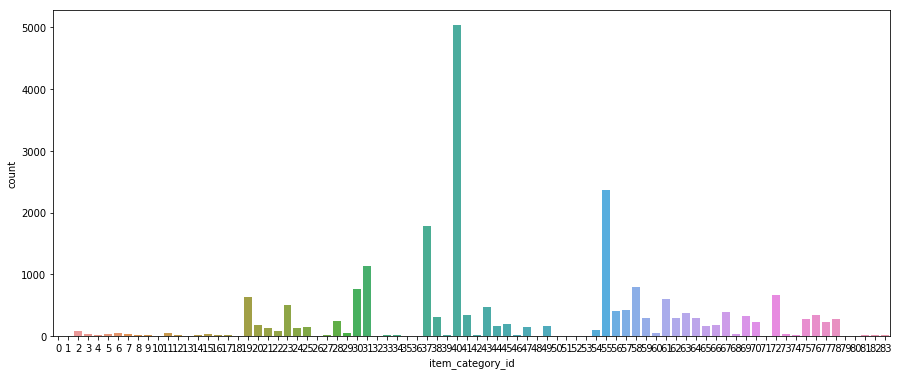

In [12]:
_, ax = plt.subplots(figsize=(15, 6))
sns.countplot(data=item, x="item_category_id", ax=ax)

In [13]:
sales["revenue"]=sales["item_price"]*sales["item_cnt_day"]
sales_p=sales[sales["item_cnt_day"]>=0]
sales_p.shape[0]-sales.shape[0]

-7356

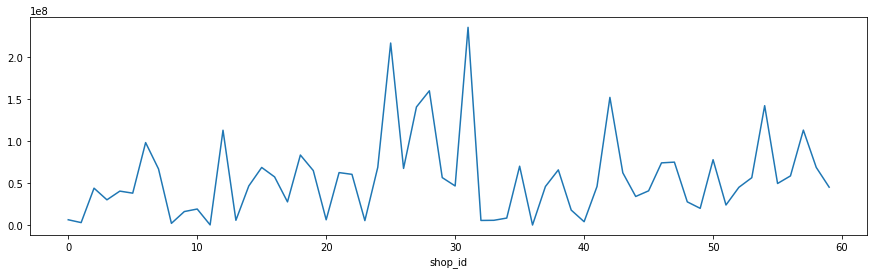

In [14]:
sales_p.groupby(["shop_id"])["revenue"].agg("sum").plot(figsize=(15,4))

In [15]:
shops_data=sales_p.groupby(["shop_id"])[["revenue"]].agg("sum")

In [7]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [16]:
# Create a line (trace) for the global sales
trace0 = go.Scatter(
    x=shops_data.index,
    y=shops_data['revenue'],
    name='Sales by shop'
)

# Define the data array
data = [trace0]

# Set the title
layout = {'title': 'Sales by shop'}

# Create a Figure and plot it
fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

In [17]:
shops["city"]=shops["shop_name"].apply(lambda x: x.split(" ")[0])

In [18]:
shops_data_1=sales_p.groupby(["shop_id"])[["revenue"]].agg("sum").\
join(sales_p.groupby(["shop_id"])[["item_cnt_day"]].agg("count"))

In [46]:
shops_data_1.head()

,revenue,item_cnt_day
shop_id,,
0,6.637370e+06,9857
1,3.238207e+06,5678
2,4.421349e+07,25911
3,3.036145e+07,25413
4,4.071549e+07,38118


In [19]:
# Create a bar for the global sales
trace0 = go.Bar(
    x=shops_data_1.index,
    y=shops_data_1['revenue']/1000,
    name='revenue, K'
)

# Create a bar for the number of games released
trace1 = go.Bar(
    x=shops_data_1.index,
    y=shops_data_1['item_cnt_day'],
    name='Quantity sold'
)

# Get together the data and style objects
data = [trace0, trace1]
layout = {'title': 'Data on revenue & sales by shop'}

# Create a `Figure` and plot it
fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018186A705C0>]],
      dtype=object)

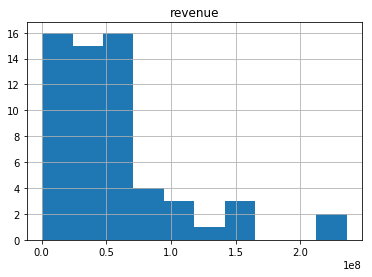

In [49]:
shops_data_1.hist("revenue")

In [51]:
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [20]:
result=pd.merge(sales_p, item, how="left", on="item_id" )

In [21]:
item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [22]:
result.drop([ "date"], axis=1, inplace=True)

In [60]:
result.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,item_name,item_category_id
0,0,59,22154,999.00,1.0,999.00,ЯВЛЕНИЕ 2012 (BD),37
1,0,25,2552,899.00,1.0,899.00,DEEP PURPLE The House Of Blue Light LP,58
2,0,25,2554,1709.05,1.0,1709.05,DEEP PURPLE Who Do You Think We Are LP,58
3,0,25,2555,1099.00,1.0,1099.00,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56
4,0,25,2564,349.00,1.0,349.00,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59


## Total sales by company 

In [15]:
tot_sales=sales.groupby("date_block_num")["item_cnt_day"].agg(["sum"])

In [8]:

tot_sales.astype("float")
tot_sales.head()

,sum
date_block_num,
0,131479.0
1,128090.0
2,147142.0
3,107190.0
4,106970.0


In [25]:
tot_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34 entries, 0 to 33
Data columns (total 1 columns):
sum    34 non-null float64
dtypes: float64(1)
memory usage: 544.0 bytes


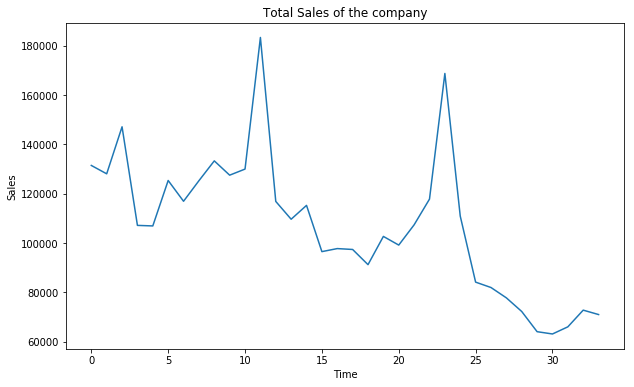

In [26]:
plt.figure(figsize=(10,6))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(tot_sales)

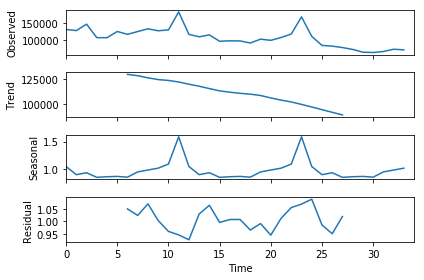

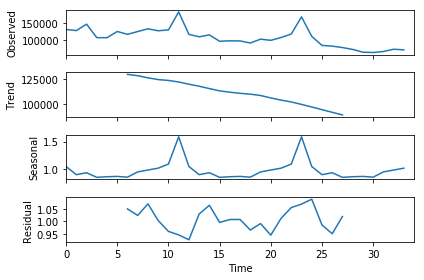

In [27]:

sm.tsa.seasonal_decompose(tot_sales.values, freq=12, model="multiplicative").plot()

#print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(tot_sales.values)[1])

Populating the interactive namespace from numpy and matplotlib
Критерий Дики-Фуллера: p=0.142953


<Figure size 720x576 with 0 Axes>

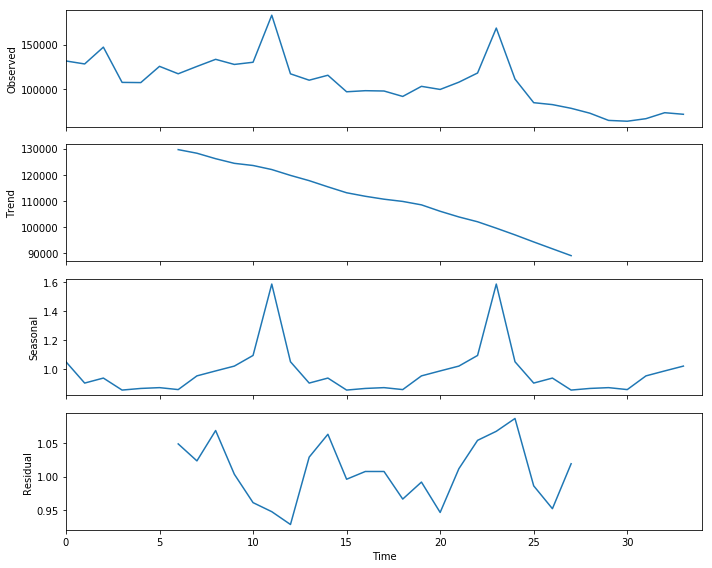

In [106]:
%pylab inline
plt.figure(figsize(10,8))
sm.tsa.seasonal_decompose(tot_sales.values, freq=12, model="multiplicative" ).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(tot_sales.values.flatten())[1])

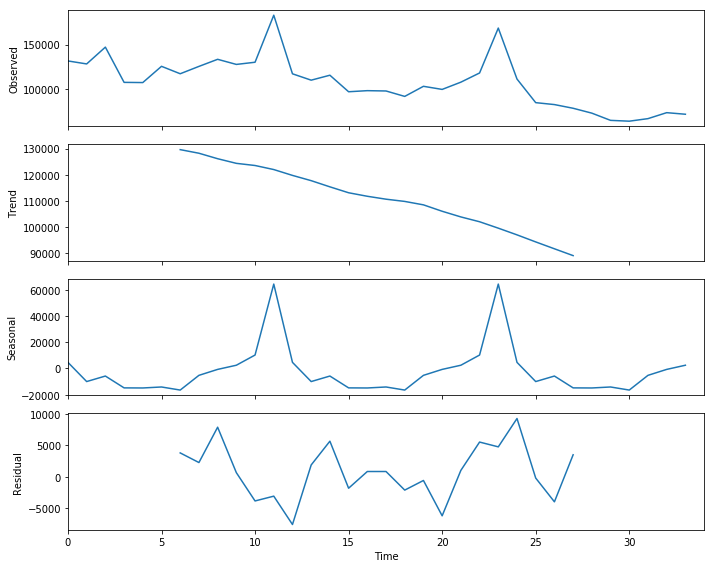

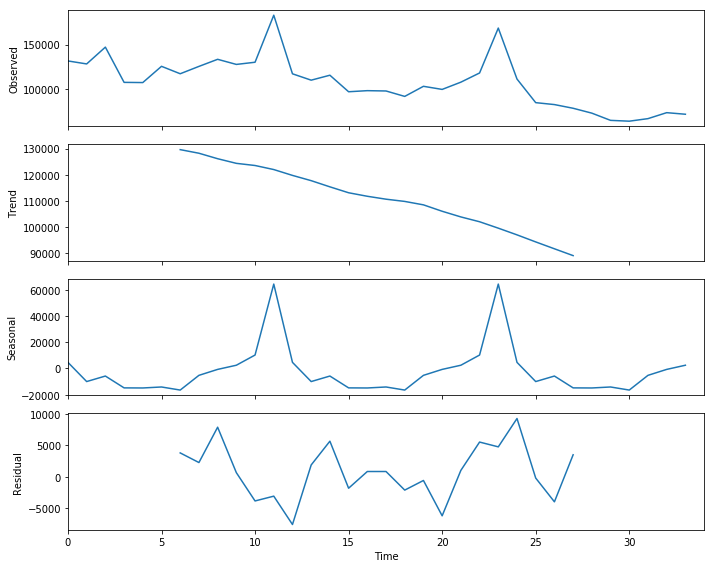

In [108]:
#plt.figure(figsize(10,8))
sm.tsa.seasonal_decompose(tot_sales.values, freq=12, model="additive" ).plot()

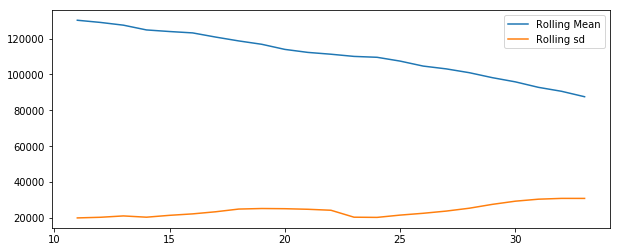

In [110]:
plt.figure(figsize=(10,4))
plt.plot(tot_sales.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(tot_sales.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

In [111]:
adfuller(tot_sales.values.flatten()) # series are stationary

(-2.3957040669944325,
 0.1429525769929046,
 0,
 33,
 {'1%': -3.6461350877925254,
  '5%': -2.954126991123355,
  '10%': -2.6159676124885216},
 530.9537360897348)

## ARMA 

In [28]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    """
        Plot time series, its ACF and PACF, QQ and PP, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 


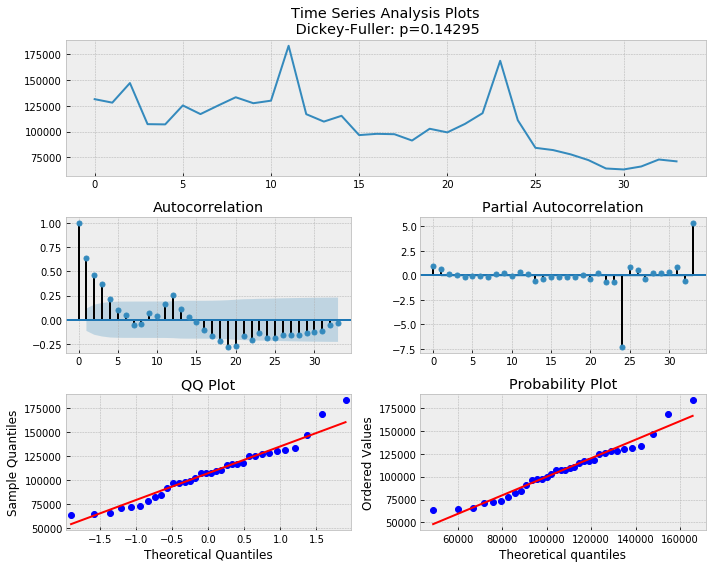

In [134]:
tsplot(tot_sales.values.flatten(), lags=33)

In [16]:
ts=pd.DataFrame(tot_sales.values.flatten(), columns=["Sales"])


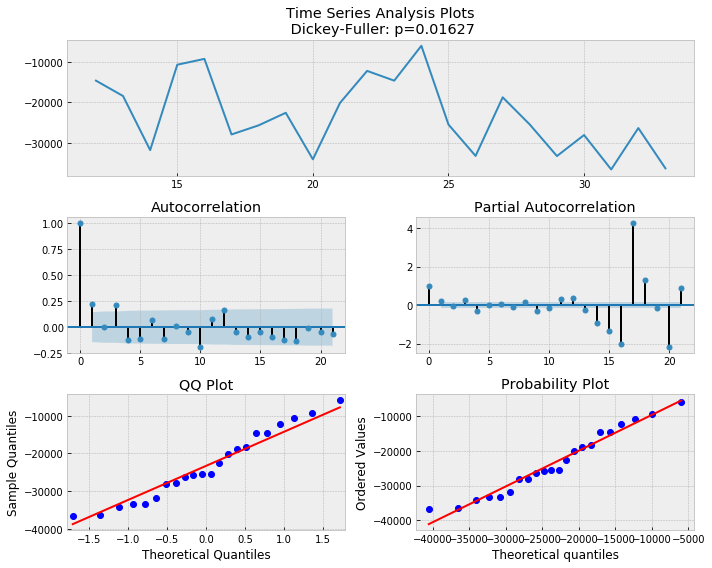

In [170]:
#take difference to remove seasonality
ts_diff = ts.Sales - ts.Sales.shift(12)
tsplot(ts_diff[12:], lags=21)

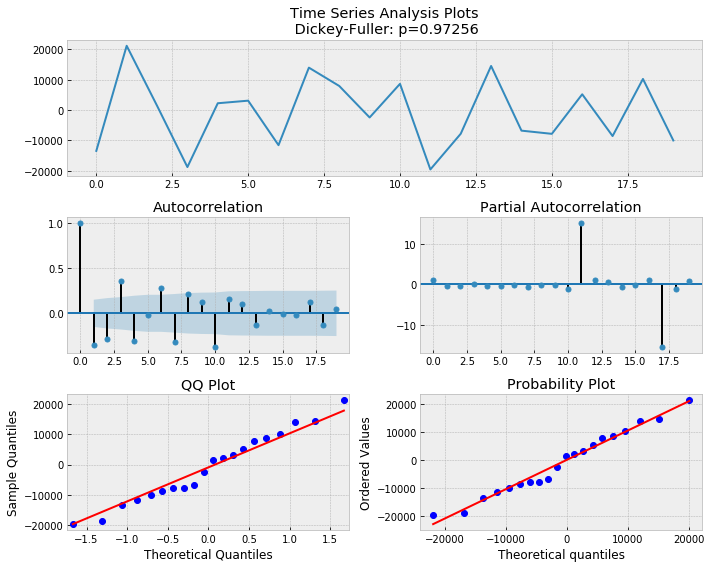

In [172]:
#take difference to differentiate lag-1. Series becomes non-stationary, this differentiating is not needed
ts_diff1 = np.diff(ts_diff)
tsplot(ts_diff1[12+1:], lags=19)

In [256]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(ts_diff[12:], order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


aic: 472.99703 | order: (1, 1)


In [258]:
print(best_mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                   22
Model:                     ARMA(1, 1)   Log Likelihood                -233.499
Method:                           mle   S.D. of innovations           9237.180
Date:                Fri, 28 Sep 2018   AIC                            472.997
Time:                        09:26:10   BIC                            476.270
Sample:                             0   HQIC                           473.768
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.Sales     0.9951      0.009    104.840      0.000       0.977       1.014
ma.L1.Sales    -0.7310      0.191     -3.822      0.001      -1.106      -0.356
                                    Roots       

In [19]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotARIMA(series, model, n_steps, s):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s steps, because these values were unobserved by the model
    # due to the differentiating
    
    
    # forecasting on n_steps forward 
 
    forecast = model.predict(start = data.shape[0]-s, end = data.shape[0]-s+n_steps) # 0 insteads of 1 needed for 1 period fcst
    seasonal=data.actual.shift(12)
    seasonal=pd.DataFrame(seasonal.append(pd.Series(data.loc[data.shape[0]-s]["actual"])).reset_index(drop=True))
    forecast = pd.DataFrame(data.arima_model.append(forecast))
    forecast.columns=["forecast"]
    forecast["seasonal"]=seasonal
    forecast["fcst+seas"]=forecast.seasonal+forecast.forecast
    
    
    # calculate error, again having shifted on s steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s:], forecast['fcst+seas'][s:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast["fcst+seas"], color='r', label="model")
    plt.axvspan(data.index[-1], forecast1.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

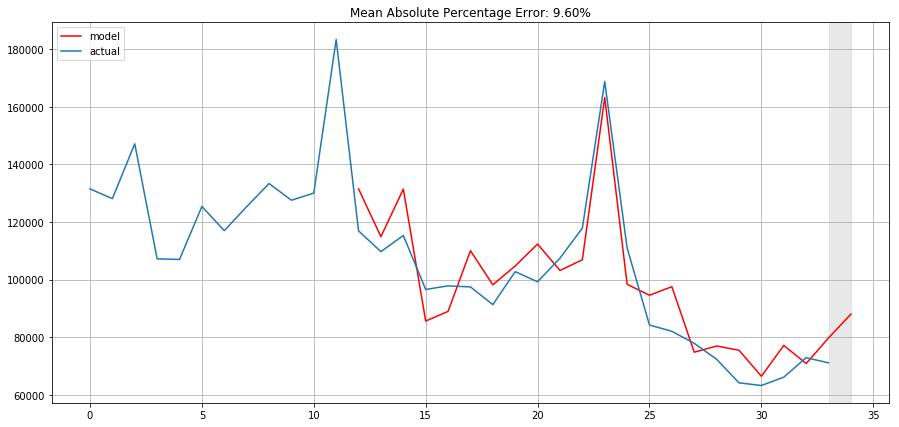

In [306]:
plotARIMA(ts, best_mdl, 0, 12)

In [20]:
ts1=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
#ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')


ts=pd.DataFrame(ts1.values, index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS'), columns=["Sales"])
ts.head()

,Sales
2013-01-01,131479.0
2013-02-01,128090.0
2013-03-01,147142.0
2013-04-01,107190.0
2013-05-01,106970.0


## SARIMA 

In [12]:
ts['Sales_cox_box'], lmbda = stats.boxcox(ts.Sales)
plt.figure(figsize(15,7))
ts.Sales_cox_box.plot()
plt.ylabel(u'Transformed sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(ts.Sales_cox_box)[1])

NameError: name 'figsize' is not defined

In [13]:
ts.rename(columns={"item_cnt_day": "Sales"}, inplace=True)
ts_diff = ts.Sales - ts.Sales.shift(12)
tsplot(ts_diff[12:], lags=21)

NameError: name 'tsplot' is not defined

In [467]:

# setting initial values and some bounds for them
ps = range(0, 4)
d=0 
qs = range(1, 3)
Ps = range(0, 2)
D=1 
Qs = range(0, 1)
s = 12 # season length 

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [468]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ts.Sales, order=(param[0], d, param[1]), enforce_stationarity=True,
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [469]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)


Wall time: 128 ms


In [470]:
result_table.head()

,parameters,aic
0,"(0, 1, 0, 0)",509.389555
1,"(0, 1, 1, 0)",509.389555
2,"(0, 2, 0, 0)",511.364696
3,"(0, 2, 1, 0)",511.364696


In [471]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(ts.Sales, order=(p, d, q), enforce_stationarity=True,
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   34
Model:             SARIMAX(0, 0, 1)x(0, 1, 0, 12)   Log Likelihood                -252.695
Date:                            Fri, 28 Sep 2018   AIC                            509.390
Time:                                    13:56:00   BIC                            511.572
Sample:                                01-01-2013   HQIC                           509.904
                                     - 10-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1996      0.094      2.115      0.034       0.015       0.385
sigma2      6.554e+08   1.63e-11   

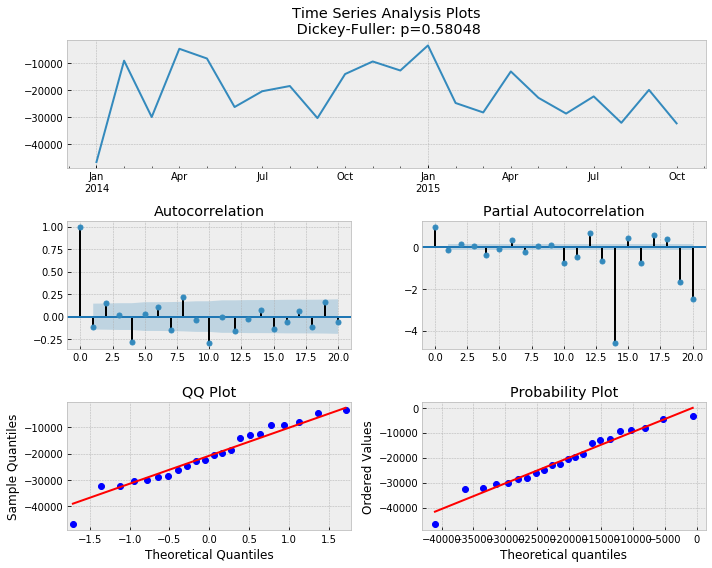

In [472]:
tsplot(best_model.resid[12+0:], lags=20)

In [473]:
s=12
d=0

In [474]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = pd.DataFrame(series.copy())
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

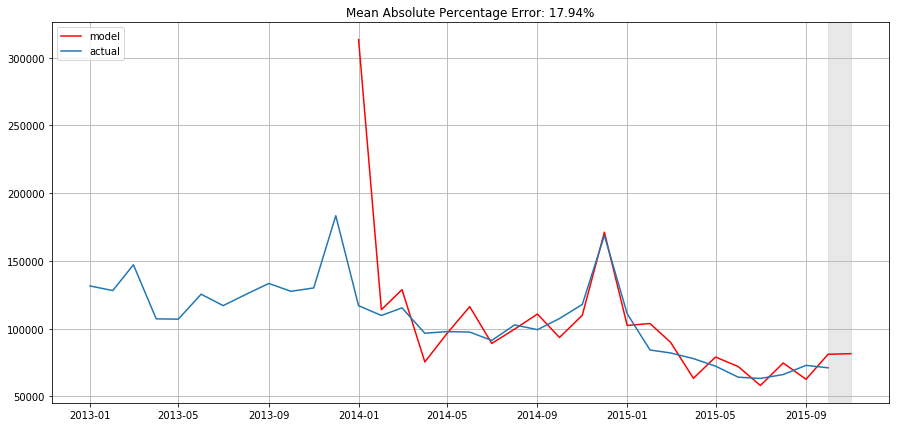

In [466]:
plotSARIMA(ts.Sales, best_model, 1)

## Prophet

In [4]:
ts1=sales.groupby(["date_block_num"])["item_cnt_day"].sum()

ts=pd.DataFrame(ts1.values, index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS'), columns=["Sales"])
ts.head()


,Sales
2013-01-01,131479.0
2013-02-01,128090.0
2013-03-01,147142.0
2013-04-01,107190.0
2013-05-01,106970.0


In [5]:
from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
ts=ts.reset_index()
ts.columns=['ds','y']


In [6]:
ts.head()

,ds,y
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


In [7]:
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 5, freq = 'M')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-10-31,93730.174147,90718.581934,96889.575786
35,2015-11-30,126112.002030,123101.217482,129220.800901
36,2015-12-31,105956.173229,102753.588379,108981.830023
37,2016-01-31,25339.794115,22149.797371,28524.878448
38,2016-02-29,30855.953667,27743.422560,33968.004738


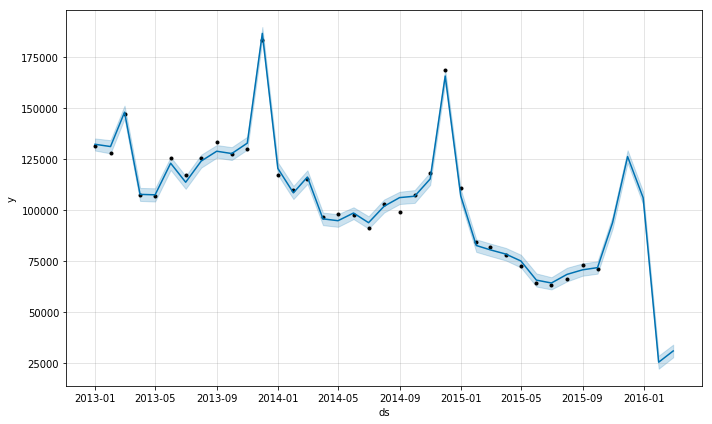

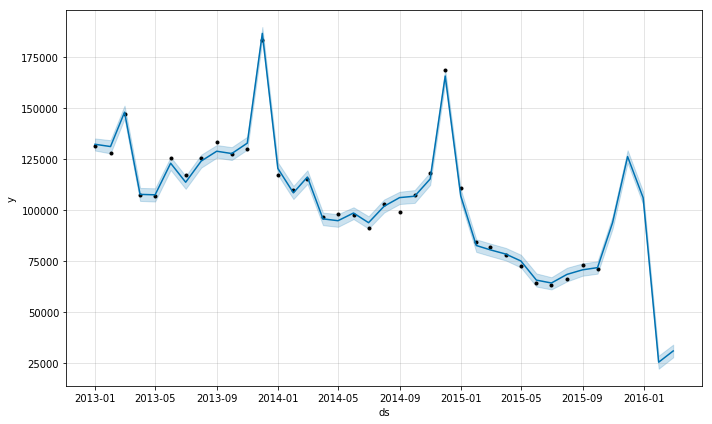

In [16]:
model.plot(forecast)

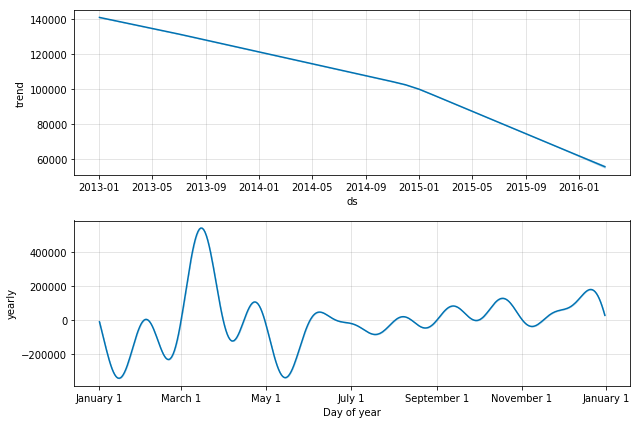

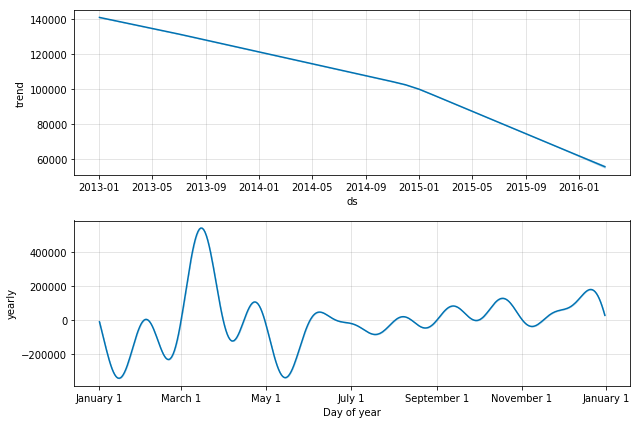

In [17]:
model.plot_components(forecast)

In [20]:
error=mean_absolute_percentage_error(ts.y, forecast['yhat'][:-5])
print("Mean Absolute Percentage Error: {0:.2f}%".format(error))

Mean Absolute Percentage Error: 1.94%


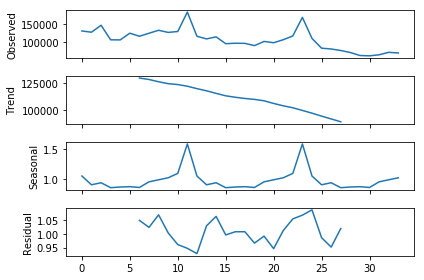

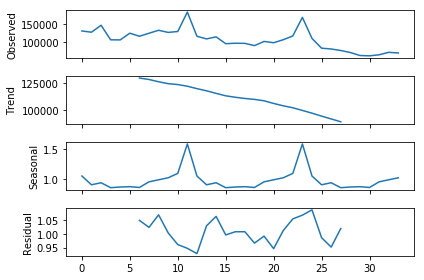

In [46]:
sm.tsa.seasonal_decompose(ts.y, freq=12, model="multiplicative").plot()

## Hierachical forecast  

In [21]:
total_sales=sales.groupby(['date_block_num'])["item_cnt_day"].sum()
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')

total_sales.index=dates
total_sales.head()

2013-01-01    131479.0
2013-02-01    128090.0
2013-03-01    147142.0
2013-04-01    107190.0
2013-05-01    106970.0
Freq: MS, Name: item_cnt_day, dtype: float64

In [22]:
#get the unique combinations of item-store from the sales data at monthly level
monthly_sales=sales.groupby(["shop_id","item_id","date_block_num"])["item_cnt_day"].sum()


In [23]:
monthly_sales=monthly_sales.unstack(level=-1).fillna(0)


In [24]:
monthly_sales=monthly_sales.T


In [25]:
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
monthly_sales.index=dates
monthly_sales=monthly_sales.reset_index()
monthly_sales.head()

shop_id      index     0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              \
item_id               30    31    32   33    35   36   40   42   43   49   51   57   59   61   75   85   88   95   96   97    98  111  115  136  149  151  152  153  198  199  210  228  282  306  308  351  407  421  438  471  479  482  484  491  496  498  534  545  556  560  582  642  651  657  668  677  687  699   700  715  783  785  810  814  816  825  831  835  839  944  947  952  963  965  970  971  987  989  990  991  992  993  996  997  998  999 1000 1001 1002 1003 1004 1005 1013 1015 1016 1017 1018 1022 1025 1027 1029 1031 1032 1035 1036 1048 1050 1065 1067 1078 1079 1085 1091 1102 1103 1109 1112 1114 1119 1122 1124 1131 1132 1137 1143 1151 1167 1195 1201 1204 1217 1224 1226 1227 1235 1243 1247 1249 1259 1264 1266 1270 1283 1300 1302 1304 1308 1317 1318 1326 1329 1332 1340 1357 1362  1398 1402 1406 1407 1408 1409 1410 1418 1420 1423 1438 1463  1470 1471 1472 1475 1481 1482 1520 1522 1523 1524 1528 1592 1595 1598 1611 1660 1665 1671 1675 1676 1720 1722 1729 1731 1736 1739 1740   
0       2013-01-01   0.0   0.0   6.0  3.0   1.0  0.0  0.0  0.0  1.0  0.0  2.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  25.0  1.0  0.0  0.0  3.0  1.0  0.0  1.0  1.0  0.0  2.0  0.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  2.0  4.0  1.0  0.0  1.0  0.0  0.0  9.0  0.0  0.0  6.0  7.0  2.0  1.0  5.0  0.0  2.0  11.0  3.0  1.0  0.0  4.0  0.0  0.0  0.0  0.0  1.0  2.0  1.0  2.0  1.0  7.0  1.0  0.0  0.0  2.0  1.0  4.0  0.0  2.0  2.0  2.0  1.0  1.0  4.0  5.0  2.0  2.0  2.0  0.0  0.0  2.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  3.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  3.0  4.0  1.0  1.0  2.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  1.0  1.0  5.0  3.0  1.0  2.0  1.0  10.0  8.0  6.0  3.0  5.0  1.0  1.0  0.0  1.0  2.0  3.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  2.0  1.0  0.0  2.0  0.0  1.0  1.0  0.0  1.0   
1       2013-02-01  31.0  11.0  10.0  3.0  14.0  1.0  1.0  1.0  0.0  2.0  3.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0   5.0  1.0  1.0  1.0  0.0  0.0  1.0  2.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0  3.0  4.0  1.0  1.0  0.0  2.0  1.0  4.0  5.0  1.0  4.0  7.0  4.0  0.0  5.0  1.0  0.0  11.0  1.0  0.0  2.0  4.0  3.0  3.0  2.0  1.0  1.0  0.0  1.0  2.0  0.0  2.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  2.0  1.0  0.0  3.0  3.0  4.0  0.0  0.0  0.0  3.0  1.0  0.0  2.0  1.0  2.0  0.0  2.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  2.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  3.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  2.0  1.0  1.0  1.0  1.0  1.0  1.0  6.0  0.0  0.0  1.0  1.0  1.0  1.0  2.0  2.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  13.0  7.0  6.0  5.0  1.0  1.0  1.0  6.0  5.0  1.0  1.0  1.0   3.0  3.0  6.0  1.0  8.0  0.0  0.0  1.0  3.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0   


In [26]:
import time
start_time=time.time()

# Bottoms up
# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_sales.iloc[:,0], monthly_sales.iloc[:, node+1]], axis = 1)
#     print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns = {"index" : 'ds'})
    nodeToForecast["y"] = nodeToForecast[nodeToForecast.columns[1]]
    nodeToForecast.drop(nodeToForecast.columns[1], axis=1, inplace=True)
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)
    if (node== 10):
        end_time=time.time()
        print("forecasting for ",node,"th node and took",end_time-start_time,"s")
        break

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonal

forecasting for  10 th node and took 12.518492460250854 s


In [27]:
monthly_sh_sales=sales.groupby(["date_block_num","shop_id"])["item_cnt_day"].sum()

In [28]:
monthly_sh_sales=monthly_sh_sales.unstack(level=1)
monthly_sh_sales=monthly_sh_sales.fillna(0)
monthly_sh_sales.index=dates
monthly_sh_sales=monthly_sh_sales.reset_index()

In [33]:
monthly_sh_sales.head()

shop_id,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,2013-01-01,5578.0,2947.0,1146.0,767.0,2114.0,0.0,3686.0,2495.0,1463.0,0.0,935.0,0.0,842.0,1178.0,1777.0,2724.0,2978.0,0.0,2856.0,3038.0,0.0,1495.0,1924.0,1948.0,1768.0,8215.0,2331.0,5548.0,7057.0,2820.0,2978.0,10173.0,1238.0,0.0,0.0,2127.0,0.0,2399.0,1704.0,0.0,0.0,1998.0,3991.0,1759.0,1708.0,1634.0,3363.0,2115.0,0.0,0.0,3406.0,2748.0,1812.0,2055.0,9386.0,0.0,3238.0,0.0,0.0,2017.0
1,2013-02-01,6127.0,3364.0,488.0,798.0,2025.0,877.0,4007.0,2513.0,1156.0,0.0,1026.0,0.0,1209.0,1036.0,1795.0,2746.0,2614.0,0.0,3341.0,2834.0,0.0,1854.0,2447.0,1941.0,1782.0,7934.0,2597.0,4546.0,5438.0,2834.0,2717.0,11160.0,1494.0,0.0,0.0,2205.0,0.0,2216.0,1670.0,0.0,0.0,1856.0,3965.0,2033.0,1823.0,1530.0,2660.0,1824.0,0.0,0.0,3054.0,2284.0,1737.0,1906.0,8075.0,0.0,2655.0,0.0,0.0,1897.0
2,2013-03-01,0.0,0.0,753.0,959.0,2060.0,1355.0,4519.0,2460.0,977.0,0.0,1017.0,0.0,1419.0,1245.0,1893.0,2835.0,3088.0,0.0,3551.0,3020.0,0.0,2233.0,2588.0,2118.0,2014.0,9732.0,3036.0,5454.0,6918.0,3151.0,3026.0,12670.0,1890.0,0.0,0.0,2568.0,0.0,2629.0,2009.0,0.0,0.0,1816.0,4953.0,2504.0,2131.0,1883.0,3103.0,1977.0,0.0,0.0,3610.0,2605.0,2034.0,2365.0,9488.0,0.0,3099.0,6586.0,3773.0,2028.0
3,2013-04-01,0.0,0.0,583.0,647.0,285.0,1008.0,3168.0,1540.0,-1.0,0.0,756.0,0.0,1364.0,1018.0,1247.0,2168.0,2118.0,0.0,2421.0,2291.0,0.0,1846.0,2297.0,1698.0,787.0,7867.0,2381.0,3946.0,4910.0,2252.0,2379.0,9621.0,1364.0,0.0,0.0,1845.0,0.0,1946.0,1375.0,0.0,0.0,1387.0,3978.0,1880.0,1628.0,1253.0,2160.0,1540.0,0.0,0.0,2740.0,1945.0,1446.0,1515.0,6726.0,0.0,2153.0,5493.0,2831.0,1388.0
4,2013-05-01,0.0,0.0,553.0,710.0,1211.0,1110.0,3022.0,1647.0,0.0,0.0,683.0,0.0,917.0,1104.0,1489.0,1931.0,2261.0,0.0,2944.0,2089.0,0.0,1646.0,1755.0,0.0,1967.0,6860.0,2148.0,3518.0,5703.0,2345.0,2304.0,9423.0,1209.0,0.0,0.0,2048.0,0.0,2019.0,1337.0,0.0,0.0,1597.0,3594.0,1624.0,1379.0,1333.0,2522.0,1724.0,0.0,0.0,2839.0,2243.0,1482.0,1767.0,7006.0,852.0,2140.0,5233.0,2308.0,1374.0


In [34]:
monthly_sh_sales_clear=monthly_sh_sales.drop()

(34, 61)

In [32]:
start_time=time.time()

# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_sh_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_sh_sales.iloc[:,0], monthly_sh_sales.iloc[:, node+1]], axis = 1)
#     print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns = {"index" : 'ds'})
    nodeToForecast["y"] = nodeToForecast[nodeToForecast.columns[1]]
    nodeToForecast.drop(nodeToForecast.columns[1], axis=1, inplace=True)
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)
    

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonal

In [35]:
#predictions = np.zeros([len(forecastsDict[0].yhat),1]) 
nCols = len(list(forecastsDict.keys()))+1
for key in range(0, nCols-1):
    f1 = np.array(forecastsDict[key].yhat)
    f2 = f1[:, np.newaxis]
    if key==0:
        predictions=f2.copy()
       # print(predictions.shape)
    else:
        predictions = np.concatenate((predictions, f2), axis = 1)

In [70]:
predictions_unknown=predictions[-7]
predictions_unknown

array([-507.63558133, -306.42323795,  825.65823373,  730.45072341,
        841.19823761, 1113.81137627, 1763.51045488, 1204.10098031,
       -215.87346697, -244.19925248,  405.20648294,   17.11242039,
       3044.78259948,   65.4851847 ,  954.10653702, 1237.33336753,
        949.07632708,  167.20190558, 1234.63786915, 1456.74069097,
         98.08081024, 1825.85362292, 1109.61702262, -516.92692552,
       1157.42434016, 5768.36875365, 1188.21682688, 3082.80218005,
       3621.5054954 ,  723.95537165,  197.147935  , 6242.43485272,
        -94.17725065,   93.32102464])

In [38]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [40]:
sales.item_price[sales.item_price<=0]

484683   -1.0
Name: item_price, dtype: float64

In [42]:
sales[sales.item_price<=0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [60]:
sales[(sales.item_id==2973) & (sales.shop_id==32) ]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
67427,2013-01-29,0,32,2973,2499.0,1.0
67428,2013-01-25,0,32,2973,2499.0,1.0
67429,2013-01-22,0,32,2973,2499.0,1.0
67430,2013-01-21,0,32,2973,2499.0,1.0
67431,2013-01-18,0,32,2973,2499.0,1.0
67432,2013-01-17,0,32,2973,2499.0,1.0
67433,2013-01-15,0,32,2973,2499.0,3.0
187844,2013-02-05,1,32,2973,2499.0,1.0
187845,2013-02-14,1,32,2973,2499.0,1.0
484682,2013-05-23,4,32,2973,1249.0,1.0


In [118]:
sales.at[484683,"item_price"]=2499.0

In [67]:
sales[sales.item_cnt_day<=0 ].shape[0]/sales.shape[0]

0.0025055784544777337

In [71]:
sales_minus=sales[sales.item_cnt_day<=0 ]

In [180]:
sales1.pivot_table(index="date_block_num", columns="shop_id", values="item_cnt_day", aggfunc="sum" )

shop_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
date_block_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5578.0,2947.0,1146.0,767.0,2114.0,NaN,3686.0,2495.0,1463.0,NaN,935.0,NaN,842.0,1178.0,1777.0,2724.0,2978.0,NaN,2856.0,3038.0,NaN,1495.0,1924.0,1948.0,1768.0,8215.0,2331.0,5548.0,7057.0,2820.0,2978.0,10173.0,1238.0,NaN,NaN,2127.0,NaN,2399.0,1704.0,NaN,NaN,1998.0,3991.0,1759.0,1708.0,1634.0,3363.0,2115.0,NaN,NaN,3406.0,2748.0,1812.0,2055.0,9386.0,NaN,3238.0,NaN,NaN,2017.0
1,6127.0,3364.0,488.0,798.0,2025.0,877.0,4007.0,2513.0,1156.0,NaN,1026.0,NaN,1209.0,1036.0,1795.0,2746.0,2614.0,NaN,3341.0,2834.0,NaN,1854.0,2447.0,1941.0,1782.0,7934.0,2597.0,4546.0,5438.0,2834.0,2717.0,11160.0,1494.0,NaN,NaN,2205.0,NaN,2216.0,1670.0,NaN,NaN,1856.0,3965.0,2033.0,1823.0,1530.0,2660.0,1824.0,NaN,NaN,3054.0,2284.0,1737.0,1906.0,8075.0,NaN,2655.0,NaN,NaN,1897.0
2,NaN,NaN,753.0,959.0,2060.0,1355.0,4519.0,2460.0,977.0,NaN,1017.0,NaN,1419.0,1245.0,1893.0,2835.0,3088.0,NaN,3551.0,3020.0,NaN,2233.0,2588.0,2118.0,2014.0,9732.0,3036.0,5454.0,6918.0,3151.0,3026.0,12670.0,1890.0,NaN,NaN,2568.0,NaN,2629.0,2009.0,NaN,NaN,1816.0,4953.0,2504.0,2131.0,1883.0,3103.0,1977.0,NaN,NaN,3610.0,2605.0,2034.0,2365.0,9488.0,NaN,3099.0,6586.0,3773.0,2028.0
3,NaN,NaN,583.0,647.0,285.0,1008.0,3168.0,1540.0,-1.0,NaN,756.0,NaN,1364.0,1018.0,1247.0,2168.0,2118.0,NaN,2421.0,2291.0,NaN,1846.0,2297.0,1698.0,787.0,7867.0,2381.0,3946.0,4910.0,2252.0,2379.0,9621.0,1364.0,NaN,NaN,1845.0,NaN,1946.0,1375.0,NaN,NaN,1387.0,3978.0,1880.0,1628.0,1253.0,2160.0,1540.0,NaN,NaN,2740.0,1945.0,1446.0,1515.0,6726.0,NaN,2153.0,5493.0,2831.0,1388.0
4,NaN,NaN,553.0,710.0,1211.0,1110.0,3022.0,1647.0,NaN,NaN,683.0,NaN,917.0,1104.0,1489.0,1931.0,2261.0,NaN,2944.0,2089.0,NaN,1646.0,1755.0,NaN,1967.0,6860.0,2148.0,3518.0,5703.0,2345.0,2304.0,9423.0,1209.0,NaN,NaN,2048.0,NaN,2019.0,1337.0,NaN,NaN,1597.0,3594.0,1624.0,1379.0,1333.0,2522.0,1724.0,NaN,NaN,2839.0,2243.0,1482.0,1767.0,7006.0,852.0,2140.0,5233.0,2308.0,1374.0
5,NaN,NaN,832.0,784.0,1464.0,1393.0,3847.0,2085.0,NaN,NaN,764.0,NaN,1710.0,1358.0,1863.0,2419.0,3075.0,906.0,3144.0,2638.0,NaN,1912.0,2243.0,NaN,2599.0,8478.0,2661.0,275.0,7056.0,2803.0,2794.0,10072.0,1493.0,NaN,NaN,2280.0,NaN,1829.0,1539.0,NaN,NaN,2185.0,4349.0,2060.0,1666.0,1785.0,2865.0,1654.0,NaN,NaN,3761.0,2200.0,1815.0,2125.0,8101.0,728.0,3105.0,5987.0,2972.0,1707.0
6,NaN,NaN,807.0,721.0,1378.0,1265.0,3360.0,2031.0,NaN,NaN,800.0,NaN,723.0,1094.0,1709.0,2599.0,2898.0,1044.0,2676.0,2459.0,NaN,1860.0,1903.0,NaN,2377.0,7361.0,2163.0,4148.0,6739.0,2205.0,2438.0,9500.0,93.0,NaN,NaN,2041.0,NaN,1293.0,1453.0,NaN,NaN,1997.0,3801.0,1632.0,1487.0,1507.0,2966.0,1329.0,NaN,NaN,3235.0,2273.0,1616.0,1975.0,7225.0,795.0,3294.0,5827.0,3122.0,1747.0
7,NaN,NaN,875.0,890.0,1713.0,1510.0,3702.0,2397.0,NaN,NaN,755.0,NaN,1599.0,944.0,2216.0,2536.0,2457.0,1306.0,1778.0,2675.0,NaN,2061.0,2017.0,NaN,2304.0,7784.0,2452.0,4925.0,7521.0,2073.0,2799.0,9882.0,NaN,NaN,NaN,2391.0,NaN,1472.0,1895.0,NaN,NaN,2149.0,4035.0,1849.0,1610.0,1649.0,3315.0,1610.0,NaN,NaN,3718.0,2142.0,1772.0,2367.0,7792.0,719.0,3311.0,5413.0,2863.0,2048.0
8,NaN,NaN,945.0,1026.0,1536.0,1298.0,4208.0,2599.0,NaN,NaN,1027.0,NaN,2032.0,1153.0,796.0,2790.0,1924.0,1459.0,2774.0,2801.0,NaN,2486.0,2518.0,NaN,3072.0,9251.0,3206.0,4981.0,6753.0,2832.0,3023.0,11204.0,NaN,NaN,NaN,2473.0,NaN,1666.0,1666.0,NaN,NaN,2146.0,5093.0,2768.0,1849.0,1725.0,2963.0,1742.0,NaN,NaN,3655.0,1903.0,2125.0,2440.0,7827.0,812.0,2829.0,5213.0,2735.0,2008.0


In [77]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [110]:
shops[(shops.shop_id==40) | (shops.shop_id==43) |(shops.shop_id==11) |(shops.shop_id==10)]

,shop_name,shop_id
10,Жуковский ул. Чкалова 39м?,10
11,Жуковский ул. Чкалова 39м²,11
40,"РостовНаДону ТРК ""Мегацентр Горизонт"" Островной",40
43,"СПб ТК ""Сенная""",43


In [109]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [121]:
needed_shops=test["shop_id"].unique()

In [122]:
needed_shops

array([ 5,  4,  6,  3,  2,  7, 10, 12, 28, 31, 26, 25, 22, 24, 21, 15, 16,
       18, 14, 19, 42, 50, 49, 53, 52, 47, 48, 57, 58, 59, 55, 56, 36, 37,
       35, 38, 34, 46, 41, 44, 39, 45], dtype=int64)

In [129]:
all_shops=range(0,59)
drop_shops=set(all_shops)-set(needed_shops)

In [130]:
drop_shops

{0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54}

In [177]:
t2=sales[(sales["shop_id"]==11) & (sales["date_block_num"]==25)]
for i,j in t2.iterrows():
    t2.at[i, "shop_id"]=10



In [178]:
t2.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2461045,2015-02-27,25,10,22162,237.11,1.0
2461046,2015-02-23,25,10,22162,237.11,1.0
2461047,2015-02-20,25,10,22162,270.00,1.0
2461048,2015-02-11,25,10,22162,270.00,1.0
2461049,2015-02-10,25,10,22162,270.00,1.0


In [179]:
sales1=pd.concat([sales,t2])
sales1[(sales1["shop_id"]==10) & (sales1["date_block_num"]==25)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2461045,2015-02-27,25,10,22162,237.11,1.0
2461046,2015-02-23,25,10,22162,237.11,1.0
2461047,2015-02-20,25,10,22162,270.00,1.0
2461048,2015-02-11,25,10,22162,270.00,1.0
2461049,2015-02-10,25,10,22162,270.00,1.0
2461050,2015-02-05,25,10,22073,65.88,1.0
2461051,2015-02-09,25,10,22164,475.00,1.0
2461052,2015-02-28,25,10,21996,216.04,1.0
2461053,2015-02-05,25,10,21756,178.81,1.0
2461054,2015-02-20,25,10,21684,95.00,1.0


In [134]:
t2.pivot_table(index="item_id", columns="shop_id", values="item_cnt_day")

shop_id,2,3,4,5,6,7,11,12,14,15,16,18,19,21,22,24,25,26,27,28,29,30,31,33,34,35,37,38,39,41,42,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.000000,NaN,NaN,NaN,1.00,1.000000,1.000000,NaN,NaN,1.000000,NaN,NaN
31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,1.00,NaN,NaN,1.0,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
32,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.000000,1.200000,1.0,NaN,NaN,1.000000,1.000000,1.250000,1.0,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,1.0,NaN,1.000000,1.00,NaN,1.000000,NaN,NaN,1.000000,1.000000,NaN
33,1.0,NaN,NaN,1.0,1.000000,NaN,NaN,1.000,1.00,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,1.00,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.00,NaN,1.000000,NaN,1.000000,1.000000,NaN,NaN
36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
38,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
